In [1]:
## import packages
import os, cv2
import numpy as np 
import pandas as pd 
import math
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL
import PIL.Image

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import tensorflow as tf
from tensorflow import math
from tensorflow.keras import layers
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [2]:
# Import functions from Kaggle example code:

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(16,16))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        # plt.xticks([]); 
        # plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        
        if type(image) == str:
            image = mpimg.imread(image)
        
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)    
    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


# See https://stackoverflow.com/questions/43884463/how-to-convert-rgb-image-to-one-hot-encoded-3d-array-based-on-color-using-numpy
def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr


def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [3]:
## Create path to data

# Gianluca's Path:
#path = "/data"

## Johnathan's Path:
# path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/LULC_FinalProject/data"
## Local path
path = os.getcwd()


## Define path to the data
data_path = "{}".format(path)

In [4]:
## Classes and their respective pixel values
class_dict_pd = pd.read_csv('{}/class_dict.csv'.format(path))
class_names = class_dict_pd['name'].values.tolist()
class_rgb_vals = class_dict_pd[['r', 'g', 'b']].values.tolist()

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = class_names

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_vals)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_vals)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [5]:
# Create a dictionary for One-Hot Encoding
class_dict =  dict(zip(select_class_indices, class_rgb_vals))
class_dict

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [6]:
# Load metadata file - contains relative paths for images and masks
metadata = pd.read_csv('{}/metadata.csv'.format(path))

# Preparing metadata for use
metadata = metadata[metadata['split']=='train'] # Filter out images that do not have masks (those images are part of the challenge set)
metadata = metadata[['image_id', 'sat_image_path', 'mask_path']] # Remove the image status column

# set paths to absolute paths rather than relative paths:
metadata['sat_image_path'] = metadata['sat_image_path'].apply(lambda img_pth: os.path.join(path, img_pth))
metadata['mask_path'] = metadata['mask_path'].apply(lambda img_pth: os.path.join(path, img_pth))
metadata.sort_values('image_id')

,image_id,sat_image_path,mask_path
15,119,C:\Users\gianl\MUSA 650\train/119_sat.jpg,C:\Users\gianl\MUSA 650\train/119_mask.png
144,266,C:\Users\gianl\MUSA 650\train/266_sat.jpg,C:\Users\gianl\MUSA 650\train/266_mask.png
456,606,C:\Users\gianl\MUSA 650\train/606_sat.jpg,C:\Users\gianl\MUSA 650\train/606_mask.png
676,855,C:\Users\gianl\MUSA 650\train/855_sat.jpg,C:\Users\gianl\MUSA 650\train/855_mask.png
120,2334,C:\Users\gianl\MUSA 650\train/2334_sat.jpg,C:\Users\gianl\MUSA 650\train/2334_mask.png
...,...,...,...
798,992507,C:\Users\gianl\MUSA 650\train/992507_sat.jpg,C:\Users\gianl\MUSA 650\train/992507_mask.png
799,994520,C:\Users\gianl\MUSA 650\train/994520_sat.jpg,C:\Users\gianl\MUSA 650\train/994520_mask.png
800,995492,C:\Users\gianl\MUSA 650\train/995492_sat.jpg,C:\Users\gianl\MUSA 650\train/995492_mask.png
801,997521,C:\Users\gianl\MUSA 650\train/997521_sat.jpg,C:\Users\gianl\MUSA 650\train/997521_mask.png


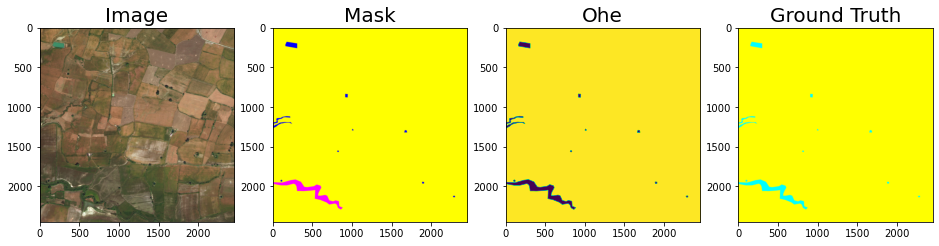

In [7]:
img_Loc = metadata['sat_image_path'][1]
mask_Loc = metadata['mask_path'][1]

img = cv2.imread(img_Loc)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ohe_mask = reverse_one_hot(cv2.imread(mask_Loc))
# ohe_mask = cv2.cvtColor(ohe_mask, cv2.COLOR_BGR2RGB)

groundTruth = colour_code_segmentation(ohe_mask, select_class_rgb_values)

visualize(Image = img, Mask = mask_Loc, OHE = ohe_mask, ground_truth = groundTruth)

# Data Ingestion and Augmentation
As mentioned above, it is advantageous to use smaller images when modeling. The code below allows us to crop our images and is borrowed and ammended from Jerin Paul. When run, the code iterates through images and corresponding masks in two separate directories, for each image-mask pair, the image and mask are opened, then a cropping filter iterates across each row and column to extract a subset image.

In [8]:
# Indentify the number of satellite images and corresponding masks
numSatImg = len(metadata['sat_image_path'])
numMask = len(metadata['mask_path'])
print("Number of original satellite images: " + str(numSatImg))
print("Number of original masks: " + str(numMask))

# Open example image & mask
img = PIL.Image.open(metadata['sat_image_path'][0])
mask = PIL.Image.open(metadata['mask_path'][0])
# Get dimensionality of that image & mask
numPixels = np.asarray(img).shape
numMaskPx = np.asarray(mask).shape
print('Number of pixels in each image: {}'.format(numPixels))
print('Number of pixels in each masks: {}'.format(numMaskPx))

Number of original satellite images: 803
Number of original masks: 803
Number of pixels in each image: (2448, 2448, 3)
Number of pixels in each masks: (2448, 2448, 3)


In [9]:
# Initialize arrays for cropped sat images and masks
# First we will need to trim the 2448 x 2448 image to 2048 x 2048 image so that it can be used with U-net 
# which needs to have images with sizes divisible by 32
# We will then crop each image down to sections of 128 x 128 x 3, which produces 256 cropped images per original sat image.
# If you want to change the size of the cropped image, change the denominator for cropimg width / height below
# cropImg_height = int((numPixels[0]-400) / 16) # 2048 / 16 = 153
# cropImg_width = int((numPixels[1]-400) / 16) # 2048 / 16 = 153


# X = np.zeros([(numSatImg * 256), cropImg_height, cropImg_width, numPixels[2]], dtype='uint8')
# y = np.zeros([(numMask * 256), cropImg_height, cropImg_width, numPixels[2]], dtype='uint8')
# print('Shape of cropped sat image dataset: {}'.format(X.shape))
# print('Shape of cropped mask dataset: {}'.format(y.shape))

cropImg_height = int((numPixels[0]-400) / 4) # 2048 / 4 = 512
cropImg_width = int((numPixels[1]-400) / 4) # 2048 / 4 = 512

X = np.zeros([(numSatImg * 16), cropImg_height, cropImg_width, numPixels[2]], dtype='uint8')
y = np.zeros([(numMask * 16), cropImg_height, cropImg_width, len(class_dict)], dtype='uint8')
print('Shape of cropped sat image dataset: {}'.format(X.shape))
print('Shape of cropped mask dataset: {}'.format(y.shape))

Shape of cropped sat image dataset: (12848, 512, 512, 3)
Shape of cropped mask dataset: (12848, 512, 512, 7)


In [10]:
# visualize(og_img = img, trimmed = trimm)
# Extract paths from pandas df to np array for iteration purposes - don't want to use iterrows b/c its slow!
Xrows = np.asarray(metadata['sat_image_path'])
yrows = np.asarray(metadata['mask_path'])


# Step 0: Trim images from 2448x2448 to 2048x24048 to make the image size divisible by 32 for Unet purposes
# Step 1: Iterate through image & corresponding mask paths and read images into memory
# Step 2: iterate through original img matrix and crop to predefined crop height & width
# Step 3: Save cropped matrix to working dataset

cropImgIdx = 0

# for i in range(0, len(Xrows)):
for i in range(0, 10):
  
  # Read and normalize image
  img = np.asarray(cv2.imread(Xrows[i]))
  mask = np.asarray(cv2.imread(yrows[i]))
  
  # Trim image to [2048,2048,3] by trimming extra 200px off from the border
  img = np.array(img[200:2248, 200:2248, :])
  mask = np.array(mask[200:2248, 200:2248, :])

  # Iterate through each row
  for r in range(0, img.shape[0], cropImg_height):
    # Iterate through each column
    for c in range(0, img.shape[1], cropImg_width):

      # Slice mask by cropping window first
      # That way we can check if if we're going to use the image or not
      newMask = np.array(mask[r:r+cropImg_height, c:c+cropImg_width, :])
      newMask = cv2.cvtColor(newMask, cv2.COLOR_BGR2RGB)
      
      # Convert mask to grayscale to find distribution of classes
      grayMask = cv2.cvtColor(newMask, cv2.COLOR_BGR2GRAY)
      # Get frequency of each classification in the cropped mask
      unique, frequency = np.unique(grayMask, return_counts= True)
      frequency = frequency / (len(grayMask.flatten()))

      # Check if any classes are represent 99% of image
      # If that is the case, throw it out
      if (frequency >= 0.99).any():
        continue

      # Try one-hot encoding of mask here
      newMask = rgb_to_onehot(newMask, class_dict)

      # Crop image if we make it past the majority class checker
      newImg = np.array(img[r:r+cropImg_height, c:c+cropImg_width, :])
      newImg = cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB)

      X[cropImgIdx,:] = newImg
      y[cropImgIdx,:] = newMask

      cropImgIdx += 1

print('There were {} images cropped from {} original images'.format((cropImgIdx-1), numSatImg))

There were 94 images cropped from 803 original images


In [11]:
cropImgIdx -= 1
X = X[0:cropImgIdx, :,:,:]
y = y[0:cropImgIdx, :,:,:]
print(X.shape)
print(y.shape)

(94, 512, 512, 3)
(94, 512, 512, 7)


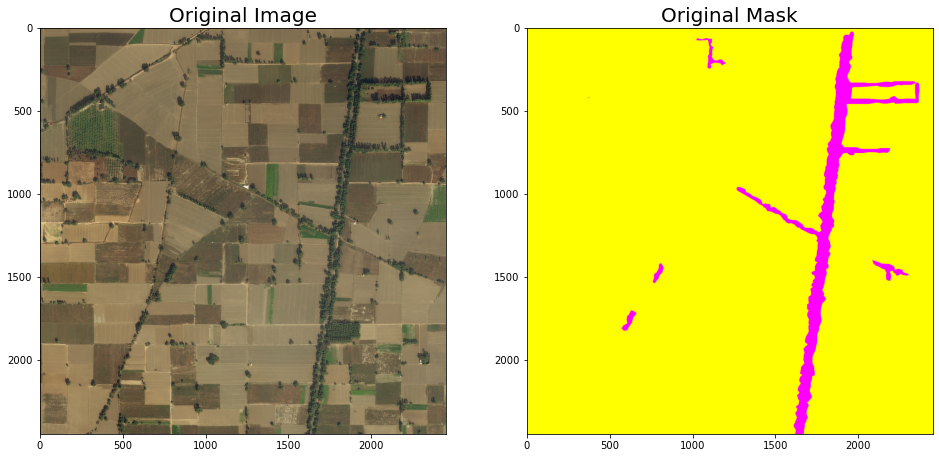

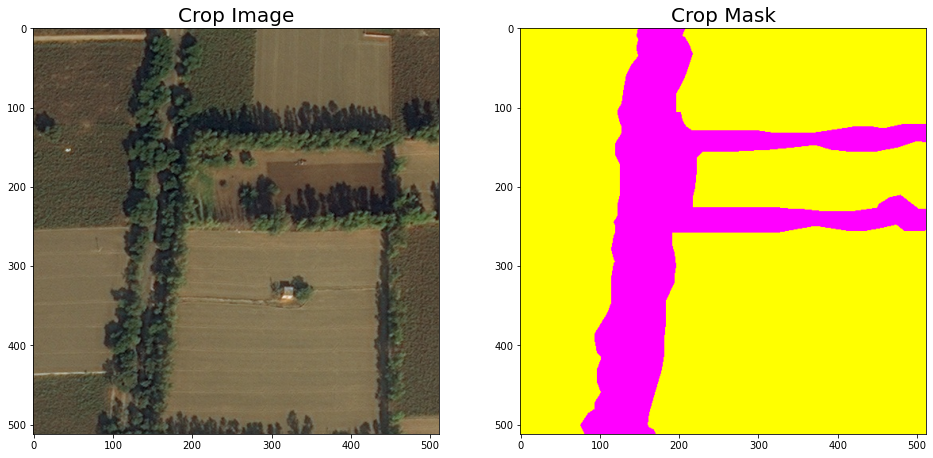

In [12]:
ogImg = Xrows[0]
ogmask = yrows[0]
cropImg = X[0]
cropMsk = onehot_to_rgb(y[0], class_dict)

visualize(original_Image = ogImg, original_Mask = ogmask)
visualize(crop_Image = cropImg, crop_Mask = cropMsk)

# U-Net model building

In [13]:
!pip install keras-unet

from keras_unet.models import vanilla_unet, custom_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [14]:
## Shuffle DataFrame
## For function origin, check this stack overflow: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_shuf, y_shuf = unison_shuffled(X, y)

In [15]:
## Downsample so that we don't break our computers
X_down = X_shuf[0:1000, :,:,:]
y_down = y_shuf[0:1000, :,:,:]
print(X_down.shape)
print(y_down.shape)


(94, 512, 512, 3)
(94, 512, 512, 7)


In [16]:
print(X_down.max(), y_down.max())

255 1


In [17]:
print(X_down.shape, y_down.shape)

(94, 512, 512, 3) (94, 512, 512, 7)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_down, y_down, test_size=0.33, random_state=42)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (62, 512, 512, 3)
y_train:  (62, 512, 512, 7)
X_test:  (32, 512, 512, 3)
y_test:  (32, 512, 512, 7)


In [21]:
## Here is a helpful guide on using Keras ImageDataGenerator to scale images 
## https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/
datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare an iterators to scale images
train_iterator = datagen.flow(X_train, y_train, batch_size=1)
test_iterator = datagen.flow(X_test, y_test, batch_size=1)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

# scalar = MinMaxScaler()
# scalar.fit(X_shuf.reshape(X_shuf.shape[0], -1))
# X_shuf = scalar.transform(X_shuf.reshape(X_shuf.shape[0], -1)).reshape(X_shuf.shape)

Batches train=62, test=32


# Hyperparameter Tuning 

In [102]:
from kerastuner.applications import HyperResNet 
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [103]:
import keras_tuner as kt
from tensorflow import keras

In [110]:
def build_model(hp):
  model = custom_unet(input_shape=(512,512,3),
                          use_batch_norm=False,
                          num_classes=len(class_names),
                          filters=64,
                          dropout=0.2,
                          output_activation='sigmoid')
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[iou, iou_thresholded])
  return model

In [113]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10, 
    hyperband_iterations=2)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


In [114]:
tuner.search(train_iterator,
             validation_data=test_iterator,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])
best_model = tuner.get_best_models(1)[0]

Trial 1 Complete [00h 16m 47s]
val_loss: 1.5604497194290161

Best val_loss So Far: 1.5604497194290161
Total elapsed time: 00h 16m 47s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
4                 |4                 |conv_blocks
96                |96                |filters_0
max               |max               |pooling_0
512               |384               |filters_1
avg               |max               |pooling_1
160               |96                |filters_2
max               |max               |pooling_2
40                |60                |hidden_size
0.2               |0.4               |dropout
0.0020709         |0.00024407        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
62/62 [==============================] - ETA: 0s - loss: 1.7760 - iou: 0.1690 


KeyboardInterrupt



# Compile + train

In [30]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

simple_unet.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [31]:
from keras.callbacks import ModelCheckpoint


model_filename = 'model1'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='binary_crossentropy', 
    save_best_only=True,
)

In [32]:
simple_unet.fit_generator(train_iterator, 
                          steps_per_epoch=len(train_iterator), 
                          epochs=5,
                          callbacks= callback_checkpoint)

Epoch 1/5
62/62 [==============================] - 367s 6s/step - loss: 0.3854 - iou: 0.1840 - iou_thresholded: 0.1559
Epoch 2/5
47/62 [=====================>........] - ETA: 1:36 - loss: 0.3437 - iou: 0.2017 - iou_thresholded: 0.2594


KeyboardInterrupt

